In [17]:
using Oceananigans
using CairoMakie
using Statistics
using Interpolations

# 1D Advection of a tracer

In [61]:
order = 3
N = 64
advection = "WENO"

prettyname(advection, order, N) = L"%$advection-$%$order$-$%$N$"
foldername(advection, order, N) = "$advection-$order-$N"
filename(advection, order, N) = joinpath("..", "scratch", "implicit-diffusion", "advection", foldername(advection, order, N), "output.jld2")

# Length and time scales
L = 1
T = 1

# Velocity
c = 1

# True solution
σ = 8L / N
@inline ψ₀(x, t) = exp(-(x - L/2 + mod(c*t, 1))^2 / 2σ^2)

ψ₀ (generic function with 1 method)

## Comparison of different advection orders

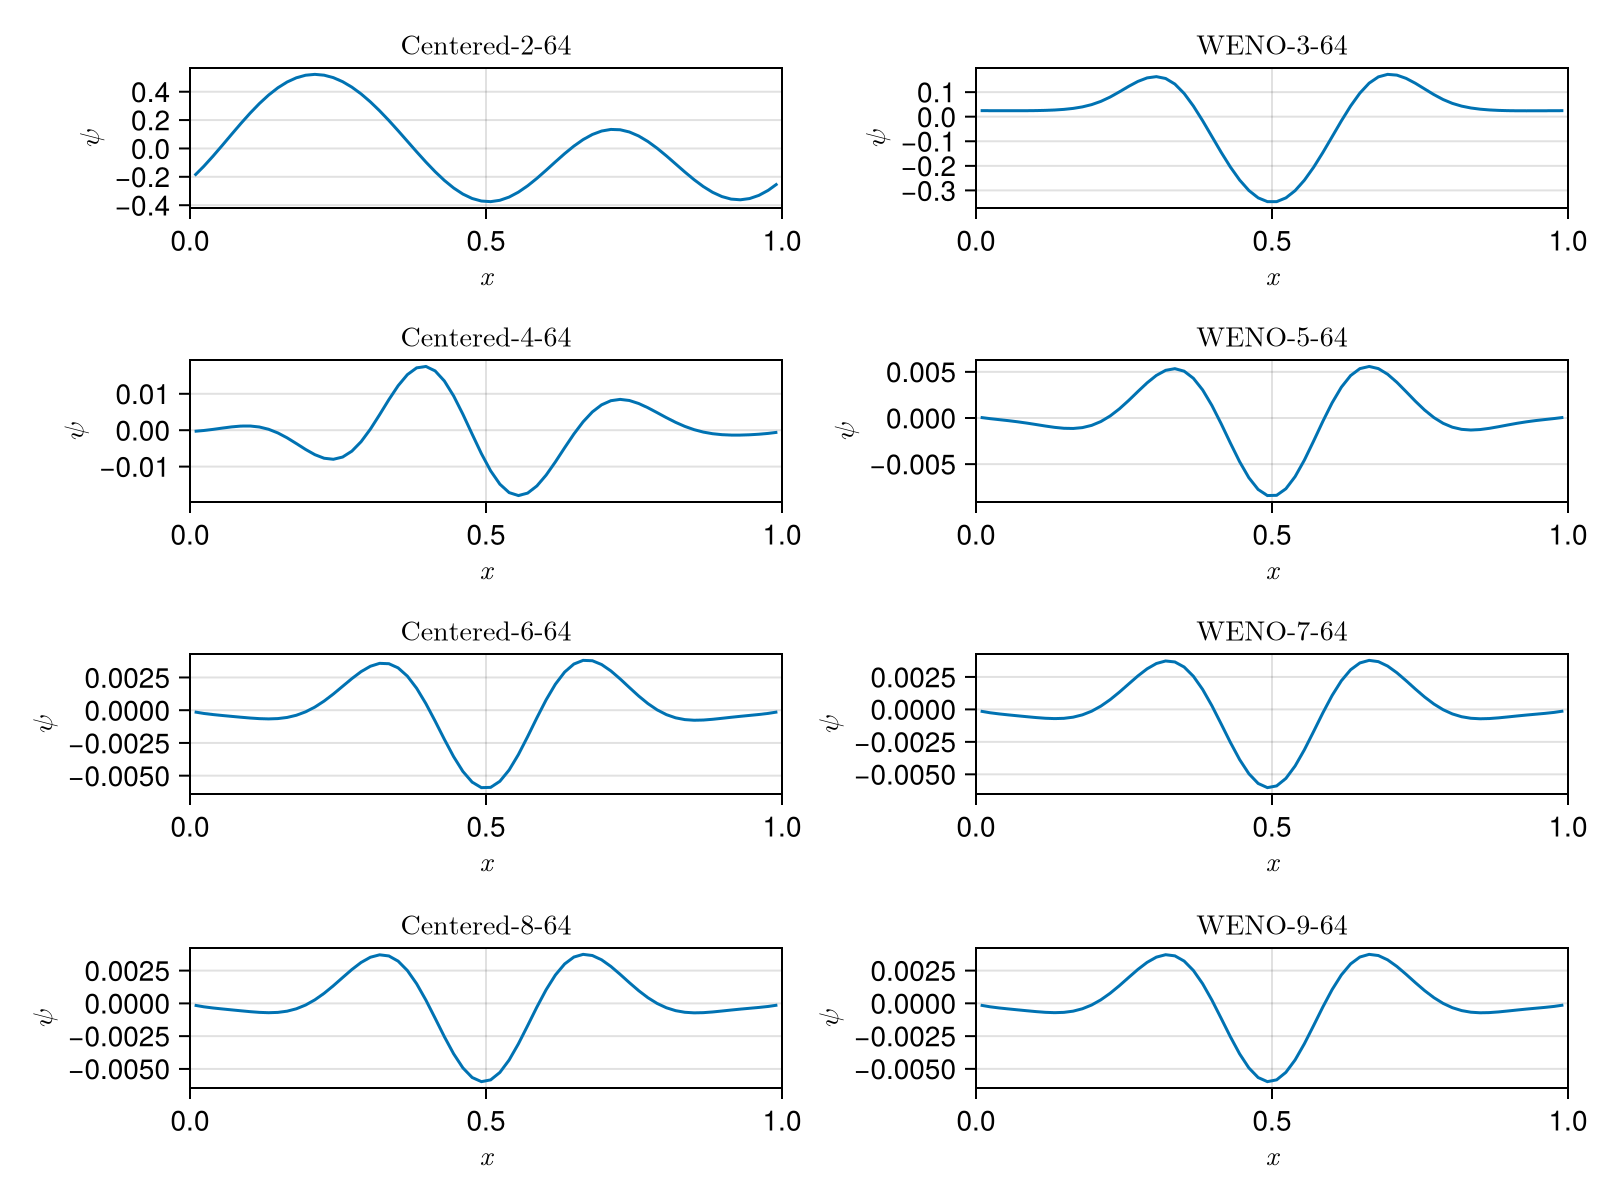

In [72]:
fig = Figure(; size=(800, 600))

even_orders = [2, 4, 6, 8]
odd_orders = [3, 5, 7, 9]

xlimits=(0, L)
ylimits=(-1, 1)

n = Observable(1001)

for (i, order) in enumerate(even_orders)
    ax = Axis(fig[i, 1]; 
        title=prettyname("Centered", order, N),
        limits=(xlimits, (nothing, nothing)),
        xlabel=L"x",
        ylabel=L"\psi"
    )
    
    ψ_series = FieldTimeSeries(filename("Centered", order, N), "ψ")
    ψs = @lift interior(ψ_series[$n], :, 1, 1) .- ψ₀.(xnodes(ψ_series), ψ_series.times[$n])
    
    lines!(ax, xnodes(ψ_series), ψs)
end

for (i, order) in enumerate(odd_orders)
    ax = Axis(fig[i, 2]; 
        title=prettyname("WENO", order, N),
        limits=(xlimits, (nothing, nothing)),
        xlabel=L"x",
        ylabel=L"\psi"
    )
    
    ψs = @lift interior(ψ_series[$n], :, 1, 1) .- ψ₀.(xnodes(ψ_series), ψ_series.times[$n])
    
    lines!(ax, xnodes(ψ_series), ψs)
end

fig

## Depth model of different advection orders

In [73]:
function depthmodel(advection, order, N; transformation=identity, savefile=false)
    ψ = FieldTimeSeries(filename(advection, order, N), "ψ")
    
    times = ψ.times
    xs = xnodes(ψ)
    
    ψs = interior(ψ, :, 1, 1, :)
    
    for (i, t) in enumerate(times)
        δx = c * t
        Δx = xs[2] - xs[1]
        ψs[:, i] .= circshift(ψs[:, i], (-δx÷Δx, ))
    end
    ψs = (ψs .- minimum(ψs)) ./ (maximum(ψs) - minimum(ψs))
    ψs = transformation.(ψs)

    if savefile
        foldername(advection, order, N)
    end
    return (xs, times, ψs)
end

depthmodel (generic function with 1 method)

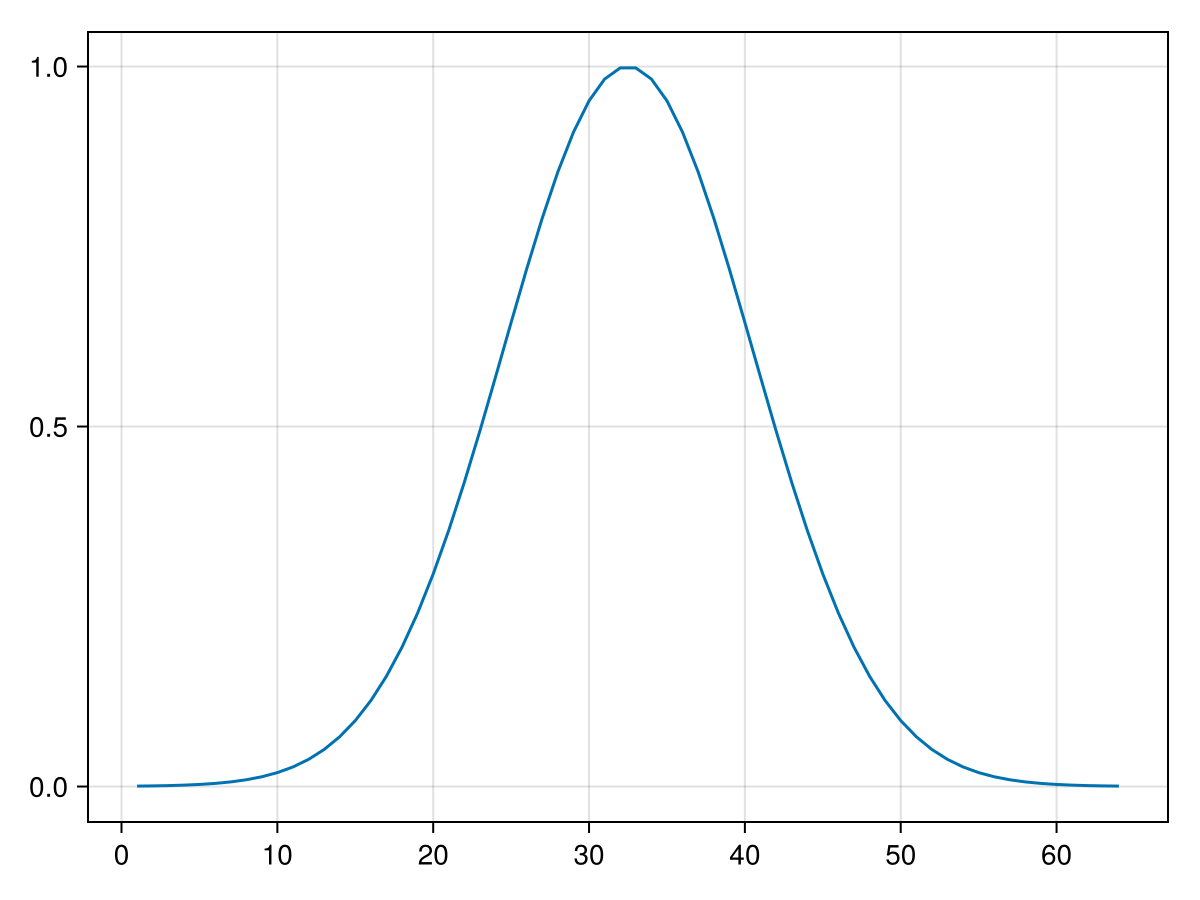

In [77]:
(xs, times, ψs) = depthmodel("Centered", 4, 64)
lines(ψs[:, 1])

# 3D convection

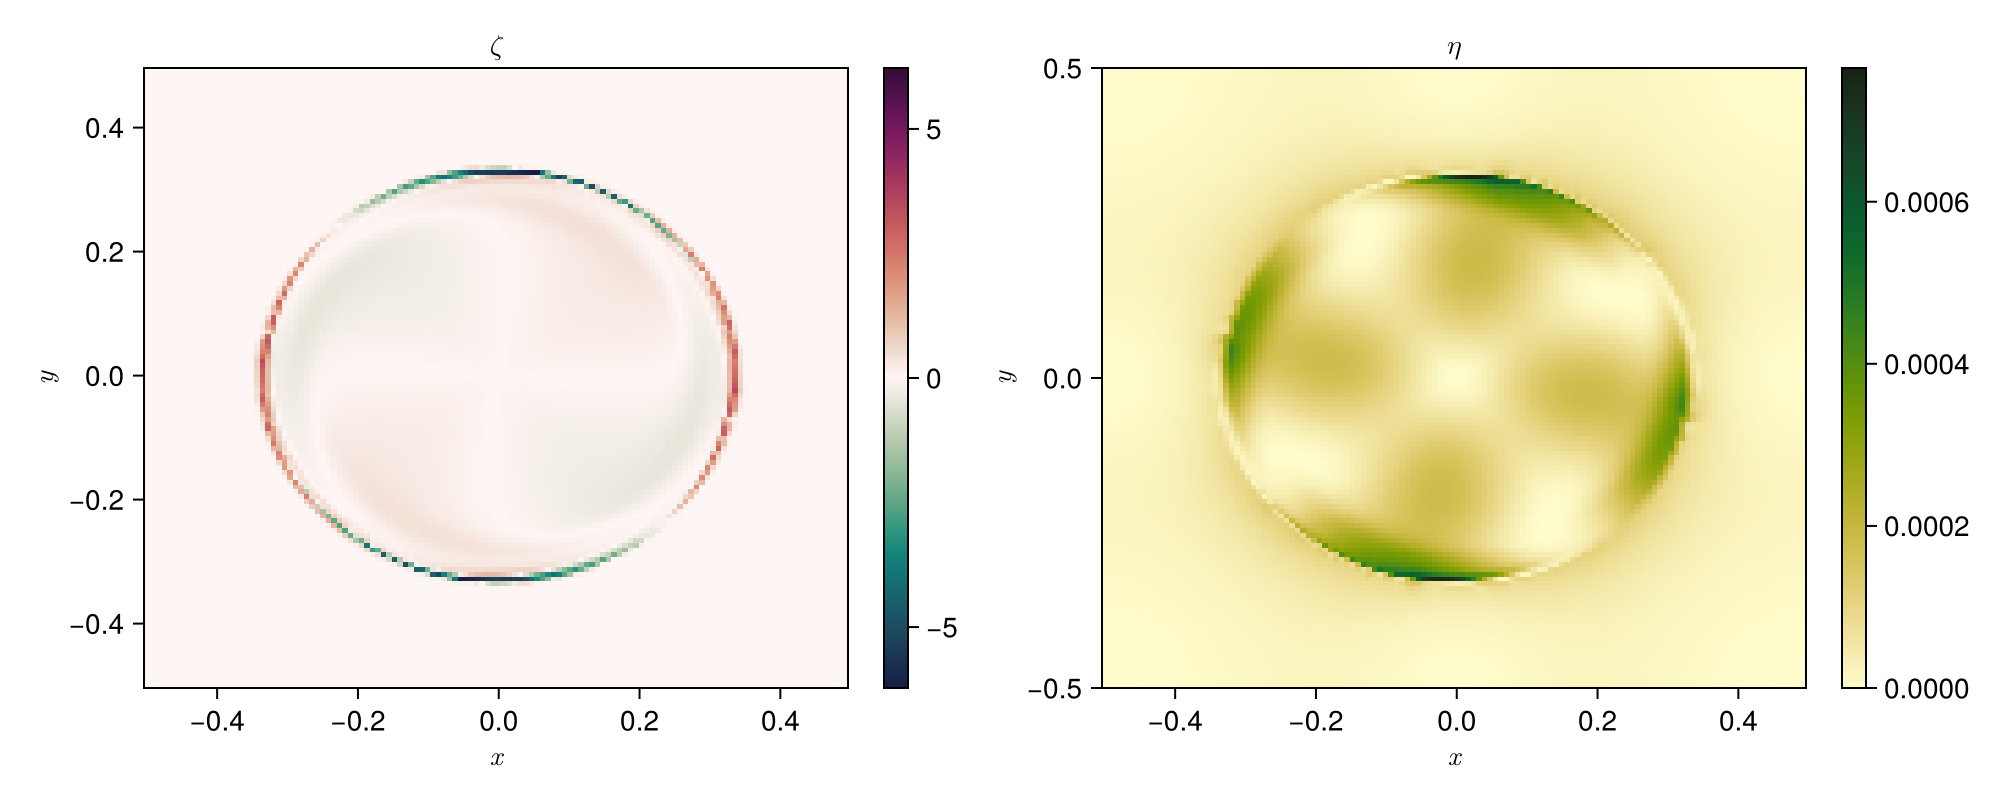

In [16]:
N = 128
foldername = joinpath("..", "scratch", "implicit-diffusion", "vortex", "WENO-$(N)", "output.jld2")

ζs = FieldTimeSeries(foldername, "ζ") #; backend=OnDisk())
ηs = FieldTimeSeries(foldername, "η") #; backend=OnDisk())

n = 81

ζ = interior(ζs[n], :, :, 1)
η = interior(ηs[n], :, :, 1)

times = ζs.times

fig = Figure(; size=(1000, 400))
ax_ζ = Axis(fig[1, 1]; xlabel=L"x", ylabel=L"y", title=L"\zeta")
ax_η = Axis(fig[1, 3]; xlabel=L"x", ylabel=L"y", title=L"\eta")

ht_ζ = heatmap!(ax_ζ, xnodes(ζs), ynodes(ζs), ζ; colormap=:curl, colorrange=(-maximum(abs, ζ), maximum(abs, ζ)))
ht_η = heatmap!(ax_η, xnodes(ηs), ynodes(ηs), η; colormap=:speed, colorrange=(0, maximum(η)))

Colorbar(fig[1, 2], ht_ζ)
Colorbar(fig[1, 4], ht_η)
fig

1001/1001


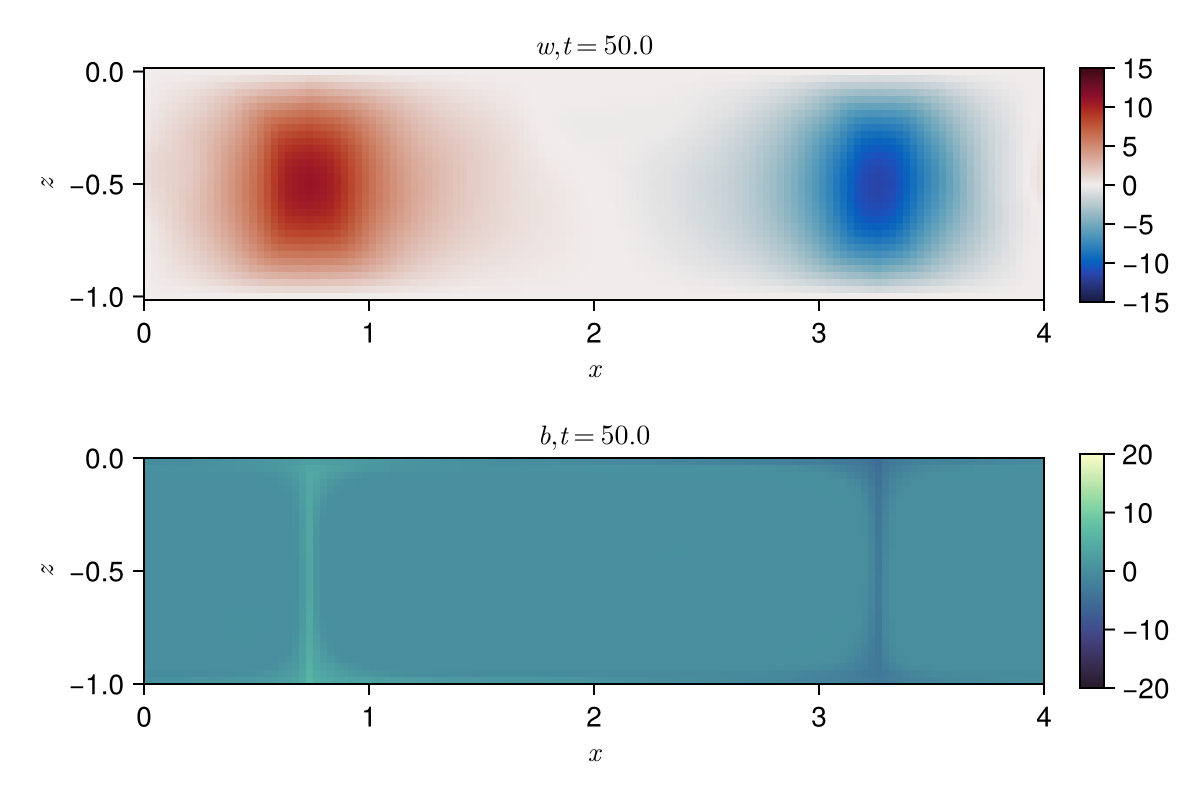

In [72]:
N = 32
foldername = joinpath("..", "scratch", "implicit-diffusion", "convection", "WENO-$(N)-2D", "output.jld2")

ws = FieldTimeSeries(foldername, "w"; backend=OnDisk())
bs = FieldTimeSeries(foldername, "b"; backend=OnDisk())

n = Observable(101)

w = @lift interior(ws[$n], :, 1, :)
b = @lift let a = interior(bs[$n], :, 1, :)
    a .- mean(a)
end

times = ws.times

w_title = @lift let t = times[$n]
    t_val = round(t; digits=2)
    L"w, t=%$(t)"
end

b_title = @lift let t = times[$n]
    t_val = round(t; digits=2)
    L"b, t=%$(t)"
end

fig = Figure(; size=(600, 400))
ax_w = Axis(fig[1, 1]; xlabel=L"x", ylabel=L"z", title=w_title, aspect=DataAspect())
ax_b = Axis(fig[2, 1]; xlabel=L"x", ylabel=L"z", title=b_title, aspect=DataAspect())

ht_w = heatmap!(ax_w, xnodes(ws), znodes(ws), w; colormap=:balance, colorrange=(-15, 15))
ht_b = heatmap!(ax_b, xnodes(bs), znodes(bs), b; colormap=reverse(to_colormap(:deep)), colorrange=(-20, 20))

Colorbar(fig[1, 2], ht_w)
Colorbar(fig[2, 2], ht_b)

record(fig, "WENO-$(N)-2D.mp4", 1:length(times)) do i
    n[] = i
    print("$i/$(length(times))\r")
end
println("")
fig

In [2]:
?@error

```
@debug message  [key=value | value ...]
@info  message  [key=value | value ...]
@warn  message  [key=value | value ...]
@error message  [key=value | value ...]

@logmsg level message [key=value | value ...]
```

Create a log record with an informational `message`.  For convenience, four logging macros `@debug`, `@info`, `@warn` and `@error` are defined which log at the standard severity levels `Debug`, `Info`, `Warn` and `Error`.  `@logmsg` allows `level` to be set programmatically to any `LogLevel` or custom log level types.

`message` should be an expression which evaluates to a string which is a human readable description of the log event.  By convention, this string will be formatted as markdown when presented.

The optional list of `key=value` pairs supports arbitrary user defined metadata which will be passed through to the logging backend as part of the log record.  If only a `value` expression is supplied, a key representing the expression will be generated using [`Symbol`](@ref). For example, `x` becomes `x=x`, and `foo(10)` becomes `Symbol("foo(10)")=foo(10)`.  For splatting a list of key value pairs, use the normal splatting syntax, `@info "blah" kws...`.

There are some keys which allow automatically generated log data to be overridden:

  * `_module=mod` can be used to specify a different originating module from the source location of the message.
  * `_group=symbol` can be used to override the message group (this is normally derived from the base name of the source file).
  * `_id=symbol` can be used to override the automatically generated unique message identifier.  This is useful if you need to very closely associate messages generated on different source lines.
  * `_file=string` and `_line=integer` can be used to override the apparent source location of a log message.

There's also some key value pairs which have conventional meaning:

  * `maxlog=integer` should be used as a hint to the backend that the message should be displayed no more than `maxlog` times.
  * `exception=ex` should be used to transport an exception with a log message, often used with `@error`. An associated backtrace `bt` may be attached using the tuple `exception=(ex,bt)`.

# Examples

```julia
@debug "Verbose debugging information.  Invisible by default"
@info  "An informational message"
@warn  "Something was odd.  You should pay attention"
@error "A non fatal error occurred"

x = 10
@info "Some variables attached to the message" x a=42.0

@debug begin
    sA = sum(A)
    "sum(A) = $sA is an expensive operation, evaluated only when `shouldlog` returns true"
end

for i=1:10000
    @info "With the default backend, you will only see (i = $i) ten times"  maxlog=10
    @debug "Algorithm1" i progress=i/10000
end
```
